In [1]:
import pandas as pd
import pickle as pkl
import netCDF4 as nc4
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt

List the deployments that have been manually labeled

In [2]:
box_dir = "/Users/frank/Box/Research/1 In progress/Gas exchange/Breathing ethogram/"
available_data = pd.read_excel(box_dir + "BreathingVideo.xlsx", 
                               engine="openpyxl",
                               sheet_name="Overview",
                               index_col=0)
available_data = available_data[available_data.index.str.contains('[A-z]{2}[0-9]{6}') == True]
available_data[["aligned", "prh_nc"]] = available_data[["aligned", "prh_nc"]].astype(bool)
available_data = available_data.query("aligned & prh_nc")
available_data

,species,n_breaths,start,stop,total_time,notes,aligned,prh_nc
id,,,,,,,,
bb180125-30,bb,64.0,(03),(05),01:15:16,After (05) camera slips to ventral position,True,True
bb190228-55b,bb,387.0,(02),NaN,04:54:30,"Interesting interactions with the boat, includ...",True,True
bb190309-52,bb,115.0,(38-44),(89),01:27:57,Can't count individual breaths while ice is in...,True,True
be180423-42,be,202.0,(02),(23-25),03:26:49,"Tag slips to left flank, but breaths still vis...",True,True
bp180526-42,bp,145.0,(02),(13),04:48:33,All videos usable!,True,True
bp180526-44,bp,140.0,(01),(12-13),05:00:20,Slips to armpit starting after (13). A few vid...,True,True
bs190322-47,bs,92.0,(01),(12),02:16:52,Mix of skim feeding and lunge feeding. Large t...,True,True
bs190322-49,bs,67.0,(08),(10),00:43:43,Surface skim feeding that looks like breathing...,True,True
bw180828-49,bw,361.0,(06-08),(64),03:16:59,Entire video usable!,True,True


Pick a deployment and read the PRH

In [3]:
export_id = "be180423-42"
nc_path = glob("/Volumes/COPYCATSdat/CATS/tag_data/prh/{}*.nc".format(export_id))
print(nc_path)
prh_nc = nc4.Dataset(nc_path[0])

['/Volumes/COPYCATSdat/CATS/tag_data/prh/be180423-42_prh10.nc']


In [4]:
whale_tz = "Etc/GMT%+i" % -prh_nc.dephist_device_tzone
dt = pd.to_datetime(np.array(prh_nc["DN"]) - 719529, unit="D", utc=True).tz_convert(whale_tz)
depth, pitch, roll = [np.array(prh_nc[var]) for var in ["P", "pitch", "roll"]]
jerk = np.sum(np.diff(np.array(prh_nc["Aw"]), append=np.nan) ** 2, axis=0)
prh_data = pd.DataFrame(index=dt, data={"depth": depth, "pitch": pitch, "roll": roll, "jerk": jerk})
prh_data.head()

,depth,pitch,roll,jerk
2018-04-23 10:23:29.779958400+02:00,0.018478,-0.795387,2.629191,0.069758
2018-04-23 10:23:29.880009600+02:00,-0.013053,-0.768443,2.610657,9.632609
2018-04-23 10:23:29.979974400+02:00,0.011487,-0.673624,2.794797,1.909810
2018-04-23 10:23:30.080025600+02:00,0.020110,-0.665208,2.951314,9.837741
2018-04-23 10:23:30.179990400+02:00,-0.010257,-0.780250,-3.133394,2.611390


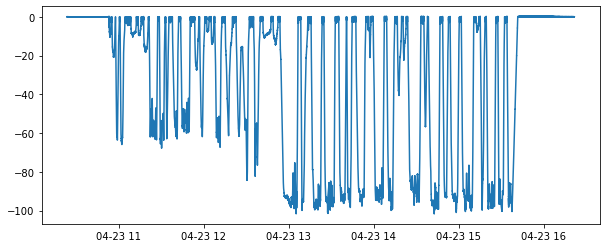

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(prh_data.index, -prh_data["depth"])
plt.show()

Match video coverage to PRH data

In [6]:
video_coverage = pd.read_excel(box_dir + "BreathingVideo.xlsx", 
                               engine="openpyxl",
                               sheet_name="Time alignment",
                               index_col=0,
                               converters = {"boristime1": str, "boristime2": str}).loc[export_id]
for col in ["camtime1", "camtime2"]:
    video_coverage[col] = video_coverage[col].dt.tz_localize(whale_tz)
for col in ["boristime1", "boristime2"]:
    video_coverage[col] = pd.to_timedelta(video_coverage[col]).dt.total_seconds()

video_coverage

,media,boristime1,camtime1,boristime2,camtime2,error_s,error_ratio,Unnamed: 8
id,,,,,,,,
be180423-42,(02),1.403,2018-04-23 10:52:59.400000+02:00,15.884,2018-04-23 10:53:14+02:00,0.119000,0.008218,NaN
be180423-42,(03),20.059,2018-04-23 10:53:34.500000+02:00,545.112,2018-04-23 11:02:20+02:00,0.447000,0.000851,NaN
be180423-42,(04),554.648,2018-04-23 11:03:05.900000+02:00,1779.078,2018-04-23 11:23:31.800000+02:00,1.470000,0.001201,NaN
be180423-42,(05),1812.248,2018-04-23 11:24:42.200000+02:00,3220.178,2018-04-23 11:48:11.600000+02:00,1.470000,0.001044,NaN
be180423-42,(06),3246.715,2018-04-23 11:49:08.400000+02:00,4488.442,2018-04-23 12:09:51.600000+02:00,1.473000,0.001186,NaN
be180423-42,(07),4504.165,2018-04-23 12:10:41.600000+02:00,6115.184,2018-04-23 12:37:33.100000+02:00,0.481000,0.000299,NaN
be180423-42,(08),6121.490,2018-04-23 12:38:23.700000+02:00,7161.926,2018-04-23 12:55:45.300000+02:00,1.164000,0.001119,NaN
be180423-42,(09),7199.424,2018-04-23 13:06:11.700000+02:00,7366.896,2018-04-23 13:08:59.100000+02:00,0.072000,0.000430,NaN
be180423-42,(10),7385.486,2018-04-23 13:11:15+02:00,7726.991,2018-04-23 13:16:56.600000+02:00,0.095000,0.000278,NaN


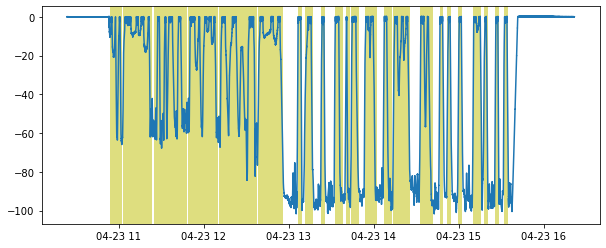

In [7]:
plt.figure(figsize=(10, 4))
plt.plot(prh_data.index, -prh_data["depth"])
for row in range(len(video_coverage)):
    plt.axvspan(video_coverage["camtime1"].iloc[row], 
                video_coverage["camtime2"].iloc[row],
                color="y", alpha = 0.5, lw=0)
plt.show()

Pick out a sample and highlight labeled breaths

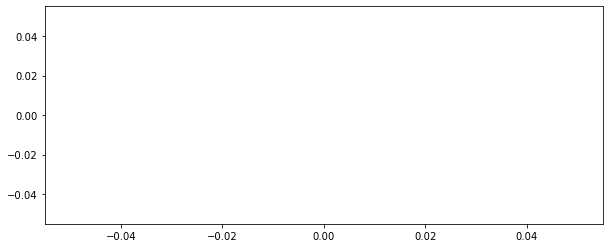

In [8]:
sample_start, sample_end = "2019-02-28 09:17:56", "2019-02-28 12:49:06"
sample_data = prh_data.loc[sample_start:sample_end]
plt.figure(figsize=(10, 4))
plt.plot(sample_data.index, -sample_data["depth"])
is_overlap = np.logical_and(video_coverage["camtime1"] < sample_end, 
                            video_coverage["camtime2"] > sample_start)
overlap_vids = video_coverage[is_overlap]
for row in range(len(overlap_vids)):
    plt.axvspan(overlap_vids["camtime1"].iloc[row], 
                overlap_vids["camtime2"].iloc[row],
                facecolor="y", alpha=0.5, lw=0)
plt.show()

In [9]:
def boristime_to_camtime(boristime):
        def interleave(l1, l2):
            result = l1 + l2
            result[::2] = l1
            result[1::2] = l2
            return result

        xs = interleave(list(video_coverage["boristime1"]), list(video_coverage["boristime2"]))
        ys = interleave(list(video_coverage["camtime1"]), list(video_coverage["camtime2"]))
        min_y = np.min(ys)
        ys_float = pd.Series(np.subtract(ys, min_y)).dt.total_seconds()
        camtime_float = np.interp(boristime, xs, ys_float)
        return min_y + pd.to_timedelta(camtime_float, unit="s")
    
breath_data = pd.read_csv(box_dir + "breaths.csv", 
                          index_col=0, 
                          usecols=[0, 3, 11, 12]).loc[export_id]
breath_data["breath_start"] = boristime_to_camtime(breath_data["Start (s)"])
breath_data["breath_end"] = boristime_to_camtime(breath_data["Stop (s)"])

breaths = breath_data["breath_start"] + (breath_data["breath_start"] - breath_data["breath_end"]) / 2
breaths

Observation id
be180423-42   2018-04-23 10:54:33.674835208+02:00
be180423-42   2018-04-23 10:55:03.824981478+02:00
be180423-42   2018-04-23 10:57:35.254290044+02:00
be180423-42   2018-04-23 11:00:24.881077720+02:00
be180423-42   2018-04-23 11:00:46.649093997+02:00
                              ...                
be180423-42   2018-04-23 15:32:30.837589525+02:00
be180423-42   2018-04-23 15:32:50.598710723+02:00
be180423-42   2018-04-23 15:33:09.549728838+02:00
be180423-42   2018-04-23 15:33:29.532105070+02:00
be180423-42   2018-04-23 15:33:49.266256129+02:00
Length: 202, dtype: datetime64[ns, Etc/GMT-2]

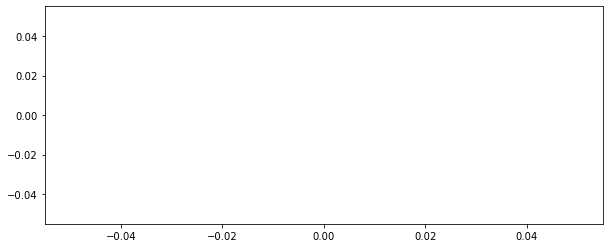

"be180423-42": ("2019-02-28 09:17:56", "2019-02-28 12:49:06")


In [10]:
overlap_breaths = breaths[np.logical_and(breaths > sample_start, breaths < sample_end)]
plt.figure(figsize=(10, 4))
plt.plot(sample_data.index, -sample_data["depth"])
is_overlap = np.logical_and(video_coverage["camtime1"] < sample_end, 
                            video_coverage["camtime2"] > sample_start)
overlap_vids = video_coverage[is_overlap]
for row in range(len(overlap_vids)):
    plt.axvspan(overlap_vids["camtime1"].iloc[row], 
                overlap_vids["camtime2"].iloc[row],
                facecolor="y", alpha=0.5, lw=0)
for i in range(len(overlap_breaths)):
    plt.axvline(overlap_breaths[i], color="r")
plt.show()

print("\"{}\": (\"{}\", \"{}\")".format(export_id, sample_start, sample_end))

In [11]:
export = {
    "bb180125-30": ("2018-01-25 16:00:18", "2018-01-25 17:00:16"),
    "bb190309-52": ("2019-03-09 12:10:00", "2019-03-09 12:40:00"),
    "be180423-42": ("2018-04-23 10:53:00", "2018-04-23 15:37:45"),
    "bp180526-42": ("2018-05-26 13:00:07", "2018-05-26 16:39:38"),
    "bp180526-44": ("2018-05-26 11:57:57", "2018-05-26 17:01:32"),
    "bs190322-47": ("2019-03-22 15:18:30", "2019-03-22 17:01:00"),
    "bs190322-49": ("2019-03-22 18:15:36", "2019-03-22 18:45:23"),
    "bw180828-49": ("2018-08-28 11:52:50", "2018-08-28 19:27:28"),
    "bw180904-48": ("2018-09-04 11:17:33", "2018-09-04 14:57:00"),
    "bw180905-53": ("2018-09-05 11:55:07", "2018-09-05 13:20:01"),
    "er160505-25": ("2016-05-05 13:54:58", "2016-05-05 18:04:23"),
    "mn170810-42": ("2017-08-10 11:17:51", "2017-08-10 16:30:52"),
    "mn170815-20": ("2017-08-15 12:31:52", "2017-08-15 13:42:36"),
    "mn190228-42": ("2019-02-28 09:17:54", "2019-02-28 12:49:03")
}

In [12]:
from ipdb import set_trace
prh_all, breaths_all = dict(), dict()
for deployid, (starttime, stoptime) in export.items():
    print("{}: {} - {}".format(deployid, starttime, stoptime))
    # load prh
    nc_path = glob("/Volumes/COPYCATSdat/CATS/tag_data/prh/{}*.nc".format(deployid))
    prh_nc = nc4.Dataset(nc_path[0])
    whale_tz = "Etc/GMT%+i" % -prh_nc.dephist_device_tzone
    dt = pd.to_datetime(np.array(prh_nc["DN"]) - 719529, unit="D", utc=True).tz_convert(whale_tz)
    depth, pitch, roll = [np.array(prh_nc[var]) for var in ["P", "pitch", "roll"]]
    jerk = np.sum(np.diff(np.array(prh_nc["Aw"]), append=np.nan) ** 2, axis=0)
    prh_data = pd.DataFrame(index=dt, data={"depth": depth, "pitch": pitch, "roll": roll, "jerk": jerk})
    
    # load breaths
    video_coverage = pd.read_excel(box_dir + "BreathingVideo.xlsx", 
                                   engine="openpyxl",
                                   sheet_name="Time alignment",
                                   index_col=0,
                                   converters = {"boristime1": str, "boristime2": str}).loc[deployid]
    for col in ["camtime1", "camtime2"]:
        video_coverage[col] = video_coverage[col].dt.tz_localize(whale_tz)
    for col in ["boristime1", "boristime2"]:
        video_coverage[col] = pd.to_timedelta(video_coverage[col]).dt.total_seconds()
    def boristime_to_camtime(boristime):
        def interleave(l1, l2):
            result = l1 + l2
            result[::2] = l1
            result[1::2] = l2
            return result

        xs = interleave(list(video_coverage["boristime1"]), list(video_coverage["boristime2"]))
        ys = interleave(list(video_coverage["camtime1"]), list(video_coverage["camtime2"]))
        min_y = np.min(ys)
        ys_float = pd.Series(np.subtract(ys, min_y)).dt.total_seconds()
        camtime_float = np.interp(boristime, xs, ys_float)
        return min_y + pd.to_timedelta(camtime_float, unit="s")
    breath_data = pd.read_csv(box_dir + "breaths.csv", 
                              index_col=0, 
                              usecols=[0, 3, 11, 12]).loc[deployid]
    breath_data["breath_start"] = boristime_to_camtime(breath_data["Start (s)"])
    breath_data["breath_end"] = boristime_to_camtime(breath_data["Stop (s)"])

    breaths = breath_data["breath_start"] + (breath_data["breath_start"] - breath_data["breath_end"]) / 2
    
    # subset and append
    sample_data = prh_data.loc[starttime:stoptime]
    sample_data.index.names = ["time"]
    sample_breaths = breaths[np.logical_and(breaths > starttime, breaths < stoptime)]
    prh_all[deployid] = sample_data.copy()
    breaths_all[deployid] = sample_breaths.copy()

bb180125-30: 2018-01-25 16:00:18 - 2018-01-25 17:00:16
bb190309-52: 2019-03-09 12:10:00 - 2019-03-09 12:40:00
be180423-42: 2018-04-23 10:53:00 - 2018-04-23 15:37:45
bp180526-42: 2018-05-26 13:00:07 - 2018-05-26 16:39:38
bp180526-44: 2018-05-26 11:57:57 - 2018-05-26 17:01:32
bs190322-47: 2019-03-22 15:18:30 - 2019-03-22 17:01:00
bs190322-49: 2019-03-22 18:15:36 - 2019-03-22 18:45:23
bw180828-49: 2018-08-28 11:52:50 - 2018-08-28 19:27:28
bw180904-48: 2018-09-04 11:17:33 - 2018-09-04 14:57:00
bw180905-53: 2018-09-05 11:55:07 - 2018-09-05 13:20:01
er160505-25: 2016-05-05 13:54:58 - 2016-05-05 18:04:23
mn170810-42: 2017-08-10 11:17:51 - 2017-08-10 16:30:52
mn170815-20: 2017-08-15 12:31:52 - 2017-08-15 13:42:36
mn190228-42: 2019-02-28 09:17:54 - 2019-02-28 12:49:03


In [13]:
data_summ = pd.DataFrame.from_dict({k: [len(prh_all[k]) / 10 / 3600, 
                                        len(breaths_all[k])] 
                                    for k in prh_all},
                                   orient="index", columns=["Duration (hrs)", "Breaths (count)"])
data_summ.append(pd.DataFrame({"Duration (hrs)":  data_summ["Duration (hrs)"].sum(),
                               "Breaths (count)": data_summ["Breaths (count)"].sum()},
                              index=["Total"]))

,Duration (hrs),Breaths (count)
bb180125-30,0.999722,59
bb190309-52,0.500278,22
be180423-42,4.746139,202
bp180526-42,3.658861,107
bp180526-44,5.060028,160
bs190322-47,1.708611,66
bs190322-49,0.496667,47
bw180828-49,7.577528,324
bw180904-48,3.657806,142
bw180905-53,1.415306,56


In [14]:
with open("../data/multi.pkl", "wb") as f:
    pkl.dump((prh_all, breaths_all), f)

# Medium term tags
Requires an extra step, re-interpolating from 8hz to 10hz.

*Note: I changed the cells below to markdown so they wouldn't run. Convert them back to Python to update the pair data*

def import_medterm(medterm_id):
    nc_path = glob("/Users/frank/Downloads/{}*.nc".format(medterm_id))
    prh_nc = nc4.Dataset(nc_path[0])
    whale_tz = "Etc/GMT%+i" % -prh_nc.dephist_device_tzone
    dt = pd.to_datetime(np.array(prh_nc["DN"]) - 719529, unit="D", utc=True).tz_convert(whale_tz)
    depth, pitch, roll = [np.array(prh_nc[var]) for var in ["P", "pitch", "roll"]]
    jerk = np.sum(np.diff(np.array(prh_nc["Aw"]), append=np.nan) ** 2, axis=0)
    prh_data = pd.DataFrame(index=dt, data={"depth": depth, "pitch": pitch, "roll": roll, "jerk": jerk})
    index10hz = pd.date_range(prh_data.index[0], prh_data.index[-1], 
                              freq='100ms', tz=whale_tz).round("100L")
    prh_data_10hz = (
        prh_data
        .reindex(prh_data.index.union(index10hz))
        .interpolate(method='time')
        .reindex(index10hz)
    )
    prh_data_10hz.index = pd.MultiIndex.from_product([[medterm_id], prh_data_10hz.index])
    prh_data_10hz.index.names = ["deployid", "time"]
    return prh_data_10hz

bm190916_tdr14 = import_medterm("Bm190916-TDR14")
bm190916_tdr15 = import_medterm("Bm190916-TDR15")

# Crop
t1, t2 = [str(bm190916_tdr15.index[i][1]) for i in [0, -1]]
pairdata = (
    pd.concat([bm190916_tdr14, bm190916_tdr15])
    .loc[pd.IndexSlice[:, t1:t2], :]
)
display(pairdata)
pairdata.to_pickle("../data/pairdata.pkl")